# Use PDHG in Python

In this note, we will implement a PDHG by ourselves. In the end we will compare it with the PDLP via CVXPY.

In [1]:
# # Step 1: Install necessary packages
# !pip install cvxpy
# !pip install numpy
# !pip install ortools==9.7.2996 # (The version after 9.8 is not supported for cvxpy)
# !pip install matplotlib

In [2]:
# Step 2: import packages
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

Now we check the installed packages. You should see PDLP, which is the enhanced PDHG with restarts and other heuritics.

In [3]:
# Step 3: check installed solvers
print(cp.installed_solvers())

['CLARABEL', 'ECOS', 'ECOS_BB', 'GLOP', 'GUROBI', 'OSQP', 'PDLP', 'SCIPY', 'SCS']


We will solve a randomly generated LP instance using our own PDHG and the PDLP

The problem is 
$$
\min c^\top x, \ s.t. Ax = b, \ x \ge 0 \ ,
$$
in which $A$ has $m$ rows and $n$ columns. 

The data is created as follows:

In [4]:
np.random.seed(123)
m = 100
n = 200

# Generate A, b, c so that x0 is a feasible solution
x0 = np.random.rand(n)
A = np.random.randn(m, n)
b = A @ x0
c = np.random.rand(n)

## Section 1: Implement PDHG Method

In [5]:
def compute_tolerance(A,b,c,x,y):
    primal_infeasibility = np.linalg.norm(A @ x - b)
    s = c - A.T @ y
    s[s>=0] = 0
    dual_infeasibility = np.linalg.norm(s)
    duality_gap = np.abs(c @ x - b @ y)
    return primal_infeasibility + dual_infeasibility + duality_gap


In [6]:
def compute_step_size(A):
    # compute largest singular value of A
    U, S, Vh = np.linalg.svd(A)
    return 0.9/S[0]

In [7]:
def PDHG(A,b,c,restart_frequency=1000, max_iters=10000, tol=1e-8, verbose=False):
    m, n = A.shape
    xk = np.zeros(n)
    yk = np.zeros(m)
    x_kplus1 = np.zeros(n)
    y_kplus1 = np.zeros(m)
    x_average = np.zeros(n)
    y_average = np.zeros(m)
    eta = compute_step_size(A)
    list_error = []
    last_restart_iteration = 0
    for k in range(max_iters):
        # PDHG update
        x_kplus1 = xk - eta * (c - A.T @ yk)
        x_kplus1[x_kplus1<0] = 0
        y_kplus1 = yk + eta * (b - A @ (2 * x_kplus1 - xk))
        xk = x_kplus1
        yk = y_kplus1

        # compute average iterate
        x_average = (x_average * (k - last_restart_iteration) + xk) / (k - last_restart_iteration + 1)
        y_average = (y_average * (k - last_restart_iteration) + yk) / (k - last_restart_iteration + 1)

        # compute error
        error = compute_tolerance(A,b,c,x_average,y_average)
        list_error.append(error)
        if error < tol:
            break

        # restart
        if restart_frequency > 0 and k - last_restart_iteration == restart_frequency:
            xk = x_average
            yk = y_average
            last_restart_iteration = k

    return x_average, y_average, list_error

In [8]:
# now we can call the PDHG function
x, y, list_error_norestart = PDHG(A,b,c, restart_frequency=0, max_iters=50000)
x, y, list_error_100 = PDHG(A,b,c, restart_frequency=100, max_iters=50000)
x_1000, y_1000, list_error_1000 = PDHG(A,b,c, restart_frequency=1000, max_iters=50000)
x, y, list_error_10000 = PDHG(A,b,c, restart_frequency=10000, max_iters=50000)

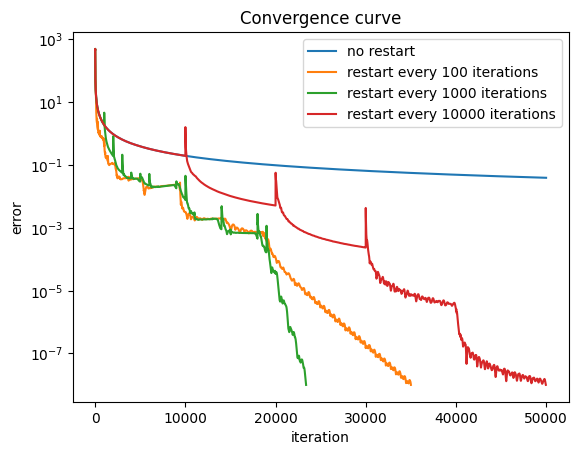

In [9]:
# draw the convergence curve
plt.plot(list_error_norestart, label='no restart')
plt.plot(list_error_100, label='restart every 100 iterations')
plt.plot(list_error_1000, label='restart every 1000 iterations')
plt.plot(list_error_10000, label='restart every 10000 iterations')
plt.legend()
plt.title('Convergence curve')
plt.xlabel('iteration')
plt.ylabel('error')
plt.yscale('log')
plt.show()

In [10]:
print("Optimal objective value of our PDHG:", c @ x_1000)

Optimal objective value of our PDHG: 26.977412126194025


## Section 2: Solve LP Using PDLP

Define the optimization variables

In [11]:
x = cp.Variable(n)

Define the objective function and constraints

In [12]:
objective = cp.Minimize(c @ x)
constraints = [A @ x == b, x >= 0]

Create the optimization problem

In [13]:
linear_problem = cp.Problem(objective, constraints)

Solve the problem using PDLP

In [14]:
linear_problem.solve(solver=cp.PDLP,verbose=True)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 20 08:26:29 PM: Your problem has 200 variables, 2 constraints, and 0 parameters.
(CVXPY) Feb 20 08:26:29 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 20 08:26:29 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 20 08:26:29 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 20 08:26:29 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 20 08:26:29 PM: Compiling problem (target solver=PDLP).
(CV

Problem stats before presolving and rescaling:
There are 200 variables, 300 constraints, and 20200 constraint matrix nonzeros.
Absolute values of nonzero constraint matrix elements: largest=4.068097, smallest=0.000003, avg=0.801799
Constraint matrix, infinity norm: max(row & col)=4.068097, min_col=1.952849, min_row=1.000000
Constraint bounds statistics (max absolute value per row): largest=20.686579, smallest=0.249714, avg=2.503605, l2_norm=91.715790
Absolute values of objective vector elements: largest=0.979927, smallest=0.002987, avg=0.487674, l2_norm=7.914897
Gaps between variable upper and lower bounds: #finite=0 of 200, largest=0.000000, smallest=0.000000, avg=nan
Problem stats after presolving and rescaling:
There are 200 variables, 100 constraints, and 20000 constraint matrix nonzeros.
Absolute values of nonzero constraint matrix elements: largest=0.274886, smallest=0.000000, avg=0.067226
Constraint matrix, infinity norm: max(row & col)=0.274886, min_col=0.193457, min_row=0.2024

26.977395136969182

Display the results

In [15]:
print("Optimal value:", linear_problem.value)

Optimal value: 26.977395136969182
